In [2]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

# Some more imports  

In [3]:
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.aqua.algorithms import QPE
from qiskit.circuit import Parameter
from qiskit.circuit.library import QFT
from qiskit.quantum_info import random_statevector
import numpy as np
pi = np.pi
sin = np.sin
cos = np.cos
exp = np.exp

/opt/conda/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


In [4]:
# time parameter
t = [pi/8, pi/16, pi/4, pi/32, pi/24]
#t = Parameter('t') #Define a universal parameter for all operators

# Defining matrix to transpile convertor, time evolution convertor(if time evolution is not already defined in the matrix, just remove the comments of evoloperator()) and my_qpe that takes in arguments and also applies inverse QFT.

In [5]:
#Operator to (1) transpile convertor
def qc(operator,qubit_list):
    qc = QuantumCircuit(len(qubit_list))
    qc.unitary(operator,qubit_list)
    qc = transpile(qc)
    return qc 

In [6]:
# my_qpe takes in work qubits, simulation qubits, initialization condition and number of repetitions gate and applies QFT inverse
def my_qpe(w_qubits,s_qubits, gate, initialize = None, repetitions=1):  
    qpe_0 = QuantumCircuit(w_qubits+s_qubits,w_qubits)
    if (initialize == 'x') :
        for i in range(s_qubits):
            qpe_0.x(i+w_qubits)
    elif (initialize == 'r'):
        initial_state = {}
        for i in range(s_qubits):
            initial_state[i] = qpe_0.initialize(random_statevector(2).data, i+w_qubits)
    elif (initialize == 'h'):
        for i in range(s_qubits):
            qpe_0.h(i+w_qubits)
    elif (initialize == 'test'):
        qpe_0.initialize([0,-1], w_qubits+0)
        qpe_0.initialize([1,0], w_qubits+1)
    elif (initialize == 's'):
        e,v = np.linalg.eig(H)
        qpe_0.initialize(v[2][0:2], w_qubits+0)
        qpe_0.initialize(v[2][2:4], w_qubits+1)
        #qpe_0.initialize(initial_state1, w_qubits+1)
    for i in range(w_qubits):
        qpe_0.h(i)
    for counting_qubit in range(w_qubits):
        for i in range(repetitions):
            qubit_list = [counting_qubit]+list(range(w_qubits,w_qubits+s_qubits))
            qpe_0.append(gate,qubit_list)
        repetitions *= 2
    qpe_1 = QFT(w_qubits, 0, True, True)
    l = [*range(w_qubits)]
    qpe = qpe_0.compose(qpe_1, l)
    qpe.measure(l,l)
    return qpe

## Testing our function definitions using Phase(as Matrix t and as circuit qc2) and CNOT operators

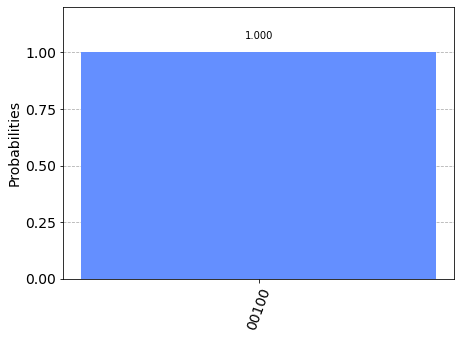

In [7]:
# phase operator as a matrix
T = ([[1,0],[0,exp(complex(0,pi/4))]])
#operator to control gate, call transpile convertor qc
T_Gate = qc(operator = T,qubit_list = [0]).to_gate().control(1)
# calling qpe for T_Gate
qpee = my_qpe(w_qubits=5,s_qubits=1,gate = T_Gate, initialize = 'x')
#display(qpee.draw()) ; # To check if it is correct 
from qiskit import execute
simulator = Aer.get_backend('qasm_simulator')
result = execute(qpee, backend = simulator, shots = 4000).result()
plot_histogram(result.get_counts(qpee))

## Q) Why do we see single peaks for $\frac{\pi}{4}$ and not for $\frac{\pi}{12}$? 
## Ans) The reason being that, for $\frac{\pi}{4}$ case we can easily break 1/8 (the $\theta$) as a decimal/$2^n$, but not for 1/24. Infact we can do this for any $\theta$ that can be divided into a single valued decimal/$2^n$. 

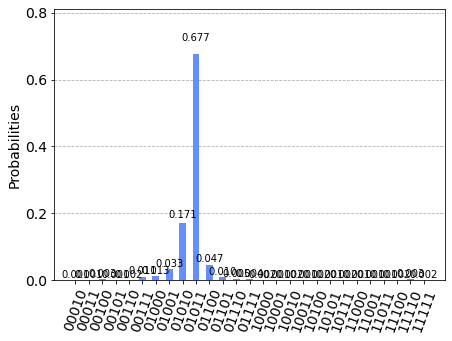

In [9]:
#Phase as a circuit
def qc2(p):
    qc2 = QuantumCircuit(1)
    qc2.p(2*pi/3,0)
    return qc2
p_gate = qc2(1).to_gate().control(1)

qppe = my_qpe(w_qubits = 5, s_qubits=1, gate = p_gate, initialize = 'x')
# we dont need to call simulator and import again
result = execute(qppe, backend = simulator, shots = 1000).result()
plot_histogram(result.get_counts(qppe))

Both circuit and matrix implementation produced the same results. Expected phase = 1/24 = 0.04166. phase obtained = 3/64 = 0.046875

## Testing with 2 qubit CNOT gate

[[(0.877583+0.479426j), 0, 0, 0],
 [0, (0.877583+0.479426j), 0, 0],
 [0, 0, (0.877583+0j), 0.479426j],
 [0, 0, 0.479426j, (0.877583+0j)]]

array([[0.92387953+0.38268343j, 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.92387953+0.38268343j,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.92387953+0.j        , 0.        +0.38268343j],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.38268343j, 0.92387953+0.j        ]])

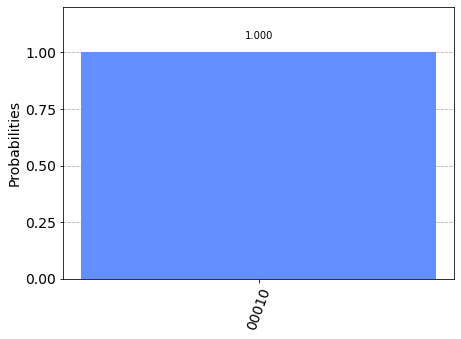

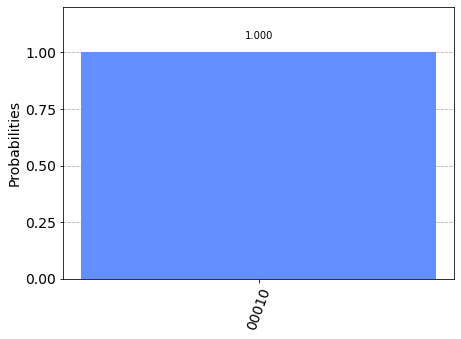

In [17]:
#exp(i(CNOT)t) where t = pi/8 using obtained using wolfram alpha
import scipy
op = ([[complex(0.877583,0.479426), 0, 0, 0],[0, complex(0.877583,0.479426), 0, 0],[0, 0, complex(0.877583,0), complex(0,0.479426),],[0, 0,complex(0,0.479426),complex(0.877583,0),]])
display(op)
op2 = ([[complex(0,pi/8),0,0,0],[0,complex(0,pi/8),0,0],[0,0,0,complex(0,pi/8)],[0,0,complex(0,pi/8),0]])
U2_op = scipy.linalg.expm(op2) # just to check that same matrix is produced by scipy exponentiation
display(U2_op)

U = qc(U2_op,[0,1]).to_gate().control(1)

qpp = my_qpe(w_qubits = 5, s_qubits=2, gate = U, initialize = 'h')
# we dont need to call simulator and import again
result = execute(qpp, backend = simulator, shots = 1000).result()
display(plot_histogram(result.get_counts(qpp)))
qpp = my_qpe(w_qubits = 5, s_qubits=2, gate = U, initialize = 'test')
# we dont need to call simulator and import again
result = execute(qpp, backend = simulator, shots = 1000).result()
display(plot_histogram(result.get_counts(qpp)))
#count = result.get_counts(qpp)


In [8]:
# Code to obtained phases from counts
from collections import Counter
def plot_to_eigenval(count,w_qubits):
    k=Counter(count).most_common(w_qubits) # Method to pick out the most probable outcomes based on number of expected eigen values
    lists = [key for key, val in k] # Convert the count dictionary to list
    for j in range(w_qubits):
        lists[j] =  int(str(lists[j]), 2) #Convert them to decimal values
    for j in range(len(lists)):
        #if (lists[j]>pow(2,w_qubits-1)):
            #lists[j] = -2*pi*(lists[j]-pow(2,w_qubits))/(pow(2,w_qubits)*t[i])
        #else :
        lists[j] = -2*pi*lists[j]/(pow(2,w_qubits)*t[i])
    print(lists)

CNOT has 2 eigen values +1 and -1 and its evolution operator has 0.877583+0.479426j and 0.877583-0.479426j, therefore we see 2 peaks in the chosen time interval(luckily, the entire spectrum). Since $\epsilon = -2\pi\frac{phase}{time}$, where $\epsilon$ in eigen value, phase = $\frac{(decimal\_value)}{2^{w\_qubits}}$ (Here we have not taken eigen value of evolution operator because then we will get a result in exponential and then we have to take log to get correct value ) expected phase = $+-\frac{0.5}{2\pi}$ = +-0.079577 and observed phase = $\frac{decimal\_value}{2^n}$ = 0.078125, 0.921875.

- Why is the other value so drastically different? 
- Since the eigen values are +- same thing, it corresponding to actually counting from left for + and right for negative value and therefore decimal for 2nd peak = 59-64 = -5 instead of 59.
Now observed phase = +-0.078125,

## Testing of Pairing part of pairing Hamiltonian for 2 qubits and for different values of t

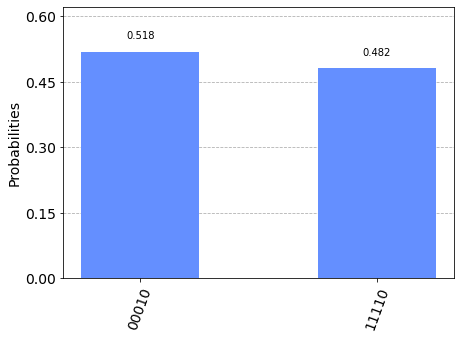

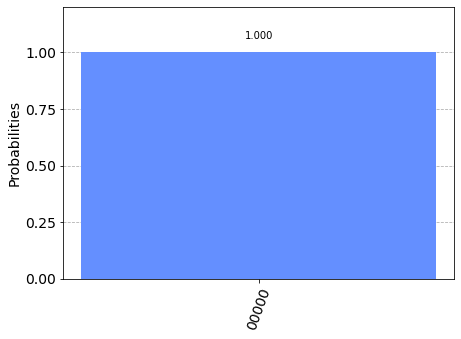

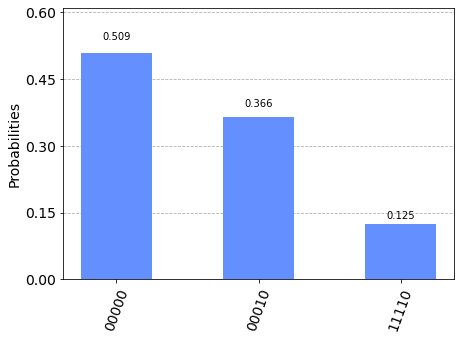

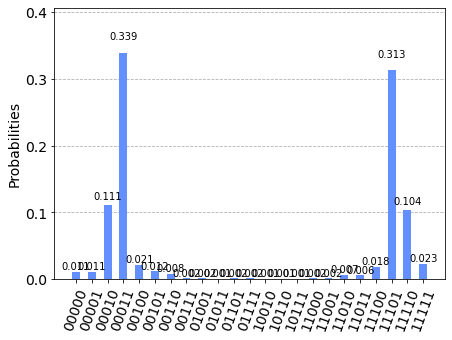

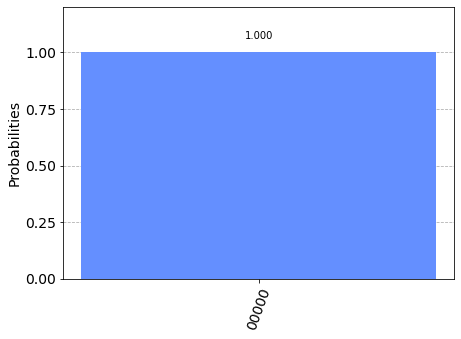

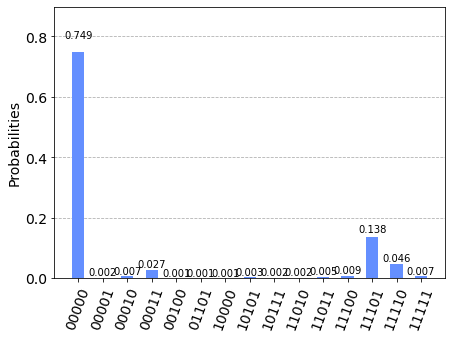

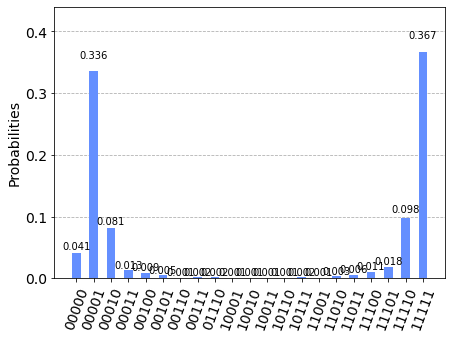

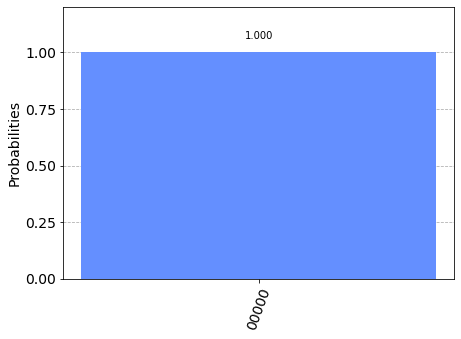

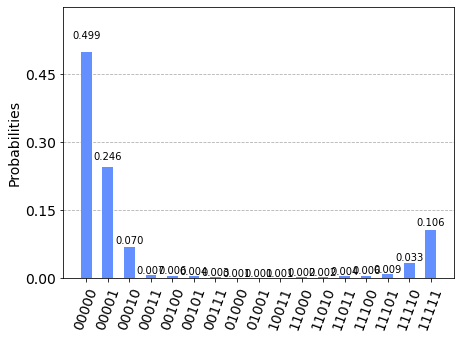

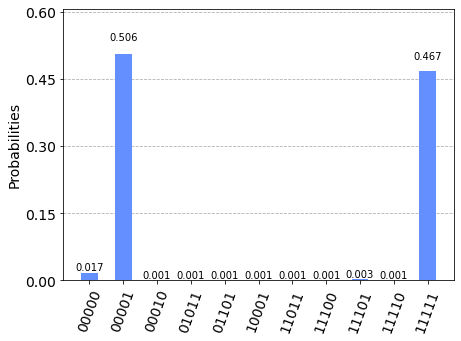

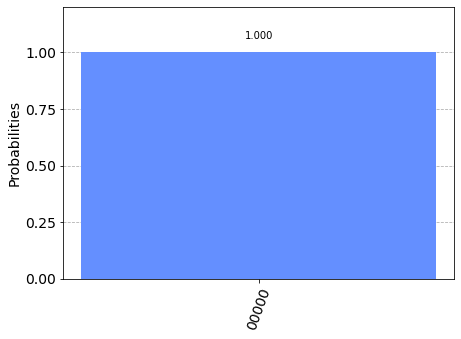

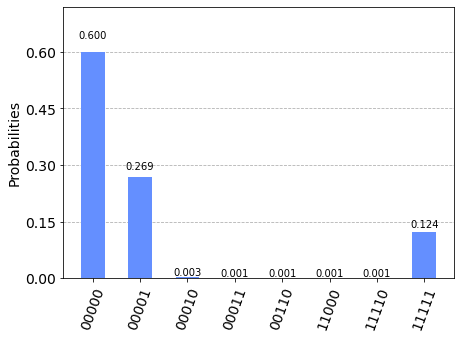

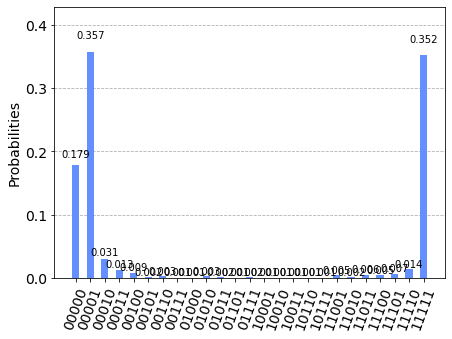

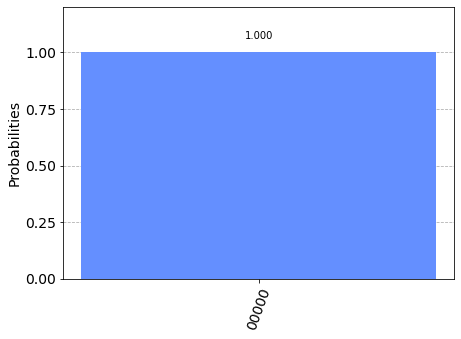

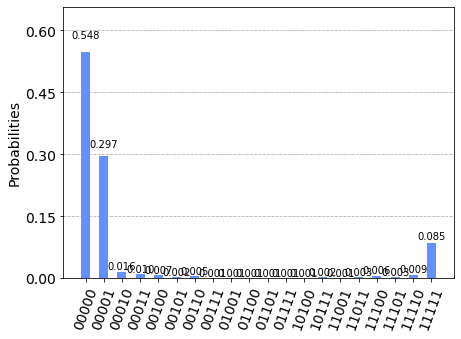

In [16]:
for i in range(len(t)):
    H = ([[1,0,0,0],[0,cos(t[i]),complex(0,sin(t[i])),0],[0,complex(0,sin(t[i])), cos(t[i]), 0],[0, 0, 0, 1]])
    #display(qch().draw())#just to see 
    Ut = qc(H,[0,1]).to_gate().control(1)
    qpevw = my_qpe(5,2,Ut,'test')
    result = execute(qpevw, backend = simulator, shots = 1000).result()
    count = result.get_counts(qpevw)
    #plot_to_eigenval(count,5)
    display(plot_histogram(result.get_counts(qpevw)))
    qpevw = my_qpe(5,2,Ut,'x')
    result = execute(qpevw, backend = simulator, shots = 1000).result()
    count = result.get_counts(qpevw)
    display(plot_histogram(result.get_counts(qpevw)))
    qpevw = my_qpe(5,2,Ut,'r')
    result = execute(qpevw, backend = simulator, shots = 1000).result()
    count = result.get_counts(qpevw)
    display(plot_histogram(result.get_counts(qpevw)))

## Eigen value via linear algebra and its comparision by above result
Put d = 0 and g = 1

H = $\frac{-1}{2}$($X_1X_0 + Y_1Y_0$ ) 
= $\begin{bmatrix} 
0 & 0 & 0 & 0 \\ 
0 & 0 & -1 & 0 \\ 
0 & -1 & 0 & 0 \\ 
0 & 0 & 0 & 0 \\ 
\end{bmatrix}$
- H in diagonal form = $\begin{bmatrix} 
-1 & 0 & 0 & 0 \\ 
0 & 1 & 0 & 0 \\ 
0 & 0 & 0 & 0 \\ 
0 & 0 & 0 & 0 \\ 
\end{bmatrix}$
$\implies$ eigen values of Hamiltonian are {-1,0,0,1}. Therefore the eigen values of evolution operator are {$e^{it}$,$e^{-it}$,1,1}. 
- Therefore if our code for 2 qubit is correct, we should get these eigen values for a given time parameter. 
- Eigen values obtained from simulation is given by $e^{i2\pi\phi} = e^{\frac{i\pi(decimal value)}{16}}$.
- Decimal value will be chosen by the bitstrings correponding to significantly high probabilities than all others.

 
 | time, t | Eigenvalues of operator | Significant binary values(from plot) | Eigenvalues from simualtion | Errors |
 | ---- | ---- | ---- | ---- | ---- |
 | $\frac{\pi}{3}$ | {(0.5+j0.866),(0.5-j0.866),1} | 0,5,(27-$2^5$) | {(0.55+j0.8314),(0.55-j0.8314),1} |  |
 | $\frac{\pi}{6}$ | {(0.866+j0.5),(0.866-j0.5),1} | 0,3,-3 | {(0.831+j0.55),(0.831-j0.55),1}|  |
 | $\frac{\pi}{12}$ | {(0.966+j0.26),(0.966-j0.26),1} | 0,1,-1 | {(0.98+j0.195),(0.98+j0.195),1} |  |
 | $\frac{\pi}{18}$ | {(0.984+j0.17),(0.984-j0.17),1} | 0,1,-1 | {(0.98+j0.195),(0.98+j0.195),1} |  |
 | $\frac{\pi}{24}$ | {(0.991+j0.13),(0.991-j0.13),1} | 0,1,-1 | {(0.98+j0.195),(0.98+j0.195),1} |  |



## Applying QPE to Pairing Hamiltonian for d=0 and g=1, number of particle 

[-2.0625, -0.0, -3.0, -7.875000000000001, -4.875000000000001, -1.8750000000000002, -5.0625]


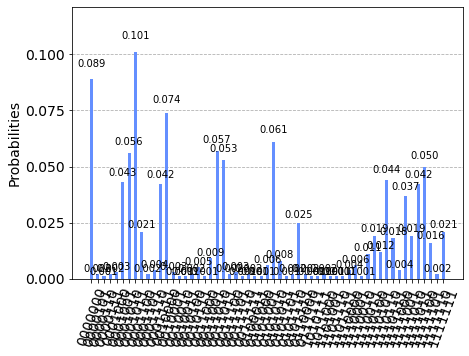

{'0101101': 1, '1010111': 1, '1110010': 1, '0111111': 1, '0011110': 1, '1101110': 1, '1111110': 2, '1101111': 1, '0010001': 3, '0110000': 2, '1111000': 4, '0011101': 3, '1011000': 2, '0000111': 2, '0001000': 3, '1101001': 1, '0101111': 25, '1111101': 16, '1111001': 37, '1110001': 6, '0010010': 1, '0001111': 42, '0001010': 56, '1110011': 11, '1111111': 21, '0011100': 2, '1110111': 18, '0001011': 101, '1111011': 42, '0011011': 53, '0000000': 89, '0101011': 8, '0001001': 43, '1111010': 19, '0001101': 2, '0101010': 61, '0011010': 57, '0001110': 4, '0101000': 1, '1111100': 50, '0101001': 6, '0010000': 74, '1110100': 19, '0001100': 21, '0101110': 2, '1110101': 12, '0011111': 2, '0000101': 2, '0010011': 1, '1110110': 44, '0000110': 1, '1110000': 4, '0010100': 2, '0011000': 1, '0100011': 1, '0010111': 5, '0011001': 9}


None

In [24]:
# Defining evolution operator for a given Hamiltonian if you do not already have matrix of evolution operator defined as operator
#This definition hass been tested to be correct by comparision with the refered papers
def evoloperator(s_qubits):
    evoloperator2 = QuantumCircuit(s_qubits)
    for p in range(s_qubits):
        for q in range(s_qubits):
            if (q > p):
                evoloperator2 = evoloperator2.compose(qc2(0,1),[p,q])
    return evoloperator2
#evolution operator : pairing part of pairing hamiltonian 
for i in range(2,3):
    UPP = ([[1,0,0,0],[0,cos(t[i]),complex(0,sin(t[i])),0],[0,complex(0,sin(t[i])),cos(t[i]),0],[0,0,0,1]])
    #QC for UPP
    def qc2(p,q):
        qc = QuantumCircuit(2)
        qc.unitary(UPP,[0,1])
        qc = transpile(qc)
        return qc 
    #converting the circuit into a controlled gate
    UPP_Gate = evoloperator(6).to_gate().control(1)
    qpe_12_par = my_qpe(7,6,UPP_Gate,'r')
    result = execute(qpe_12_par, backend = simulator, shots = 1000).result()
    count = result.get_counts(qpe_12_par)
    plot_to_eigenval(count,7)
    display(plot_histogram(result.get_counts(qpe_12_par)))
    display(print(count))

#### As expected we are  able to sample some of the eigen values for different values of t. Although we ran only 1 instance of t since it takes very long time to ssample 4-5 time intervals at once. 

## Difference in our results vs the paper :
- The initial state of their results was a random state and so do ours so, they may not match.
- The best we can expected is to match some of the eigen values by sampling many time intervals and different random initial state.

## Bug in the definition of plot_to_eigenval:
The code samples as many data points as the number of work qubits, which is mostly greater than the actual eigen value that the qpe projects, therefore we sample some extra unrequired eigen values. This can be clearly seen from the 2 qubit pairing hamiltonian data, we expect 4 but get 5 eigen values. 
The reason for this is, inorder to choose the number of significant samples from the result, an automatic correct procedure has not been implemented which is evident after seeing the plot and matching it with counts. It is also most likely possible that not all eigen values are actually present in spectrum for a given intial state and time interval but we force to display all eigen value giving incorrect value. Need to fix that.

## Else can be verified correctly



# Conclusions:

#### The codes defined for each operation works as expected. 
#### An arbitary initial state is also able to produce expected phase.
#### But along with expected result some different small peaks are also observed.
#### The number of significant high peaks correspond to number of eigen values of the evolution operator.
#### Different values t can be set to produce different parts of the eigen value spectrum.
#### There is a maximum limit to t upto which QPE can produce approximately correct results.
#### Best results are obtained if the intial state is set to eigen state of evolution operator.
